In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import stats
from IPython.display import display, HTML
from scipy.stats import pearsonr
from sklearn.preprocessing import OrdinalEncoder 

**CLEANING DATA**

In [2]:
from sklearn.preprocessing import OrdinalEncoder  
from operator import itemgetter

data = pd.read_excel(r'business_survey_results.xlsx',engine='openpyxl')
data.columns = ["V"+str(i) for i in range(1, len(data.columns)+1)]  # rename column names to be similar to R naming convention



counter=0
iters=[]
for i in range(2, len(data.columns)+1):
    rate=data["V"+str(i)].isna().sum()/len(data)
    iters.append(i)
    if rate>0.1:
        counter=counter+1
        data.drop(["V"+str(i)],axis=1,inplace=True)
        iters.remove(i)
        
#print(counter)
#print(iters)
#print(data)

le = OrdinalEncoder() 
data["V1"].fillna(data["V1"].mode()[0],inplace=True)
data["V1"] = le.fit_transform(data[["V1"]].astype(str))

for i in iters:
    if data["V"+str(i)].dtype==object:
        data["V"+str(i)].fillna(data["V"+str(i)].mode()[0],inplace=True)
        data["V"+str(i)] = le.fit_transform(data[["V"+str(i)]].astype(str))
    else:
        data["V"+str(i)].fillna(data["V"+str(i)].mean(),inplace=True)
        

corrlist=[]
for i in iters:
    
    corr,_=pearsonr(data["V"+str(i)],data["V1"])
    helper=[]
    helper.append(abs(corr))
    helper.append(i)
    corrlist.append(helper)
    
corrlist=sorted(corrlist,key=itemgetter(0),reverse=True)
    
#print(corrlist)  

datanew=data[['V1','V14','V74','V75','V12','V34']].copy()
y=datanew["V1"]
X = datanew.loc[:, "V14":]
X

,V14,V74,V75,V12,V34
0,6.0,1.0,4.0,1.0,0.0
1,4.0,0.0,0.0,3.0,2.0
2,4.0,0.0,0.0,4.0,2.0
3,1.0,0.0,0.0,3.0,0.0
4,0.0,0.0,0.0,4.0,2.0
...,...,...,...,...,...
238,6.0,2.0,4.0,0.0,0.0
239,2.0,2.0,2.0,1.0,2.0
240,4.0,0.0,0.0,0.0,1.0
241,4.0,2.0,2.0,3.0,2.0


**Statistics**

V14    3.234568
V74    1.411523
V75    1.707819
V12    1.967078
V34    1.374486
dtype: float64
V14    2.136908
V74    1.284359
V75    1.474412
V12    1.660156
V34    1.208546
dtype: float64
          V14       V74       V75       V12       V34
V14  1.000000 -0.125136 -0.163719 -0.175304  0.015384
V74 -0.125136  1.000000  0.522028 -0.063126 -0.067469
V75 -0.163719  0.522028  1.000000  0.034738 -0.097948
V12 -0.175304 -0.063126  0.034738  1.000000 -0.143584
V34  0.015384 -0.067469 -0.097948 -0.143584  1.000000


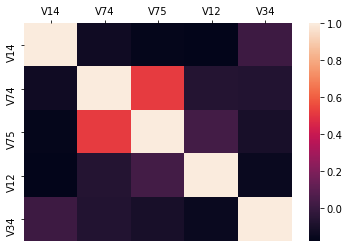

In [3]:
columnmean=[]
columnmstd=[]

columnmean=X.apply(np.mean)
print(columnmean)

columnstd=X.apply(np.std)
print(columnstd)

corrmat = X.corr()
print(corrmat)

sns.heatmap(corrmat, vmax=1., square=False).xaxis.tick_top()

**Most highly correlated**

In [4]:
def mosthighlycorrelated(mydataframe, numtoreport):
    # find the correlations
    cormatrix = mydataframe.corr()
    # set the correlations on the diagonal or lower triangle to zero,
    # so they will not be reported as the highest ones:
    cormatrix *= np.tri(*cormatrix.values.shape, k=-1).T
    # find the top n correlations
    cormatrix = cormatrix.stack()
    cormatrix = cormatrix.reindex(cormatrix.abs().sort_values(ascending=False).index).reset_index()
    # assign human-friendly names
    cormatrix.columns = ["FirstVariable", "SecondVariable", "Correlation"]
    return cormatrix.head(numtoreport)
mosthighlycorrelated(datanew, 10)

,FirstVariable,SecondVariable,Correlation
0,V74,V75,0.522028
1,V14,V12,-0.175304
2,V14,V75,-0.163719
3,V1,V14,-0.156257
4,V1,V74,-0.153371
5,V1,V75,-0.143857
6,V12,V34,-0.143584
7,V1,V12,0.143194
8,V1,V34,-0.141098
9,V14,V74,-0.125136


**Standardising Variables**

In [5]:
standardisedX = scale(X)
standardisedX = pd.DataFrame(standardisedX, index=X.index, columns=X.columns)


In [6]:
standardisedX.apply(np.mean)

V14   -8.772133e-17
V74    5.848088e-17
V75   -6.944605e-17
V12   -4.386066e-17
V34    8.772133e-17
dtype: float64

In [7]:
standardisedX.apply(np.std)

V14    1.0
V74    1.0
V75    1.0
V12    1.0
V34    1.0
dtype: float64

**PCA**

In [8]:
pca = PCA().fit(standardisedX)

In [9]:
def pca_summary(pca, standardised_data, out=True):
    names = ["PC"+str(i) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    a = list(np.std(pca.transform(standardised_data), axis=0))
    b = list(pca.explained_variance_ratio_)
    c = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    columns = pd.MultiIndex.from_tuples([("sdev", "Standard deviation"), ("varprop", "Proportion of Variance"), ("cumprop", "Cumulative Proportion")])
    summary = pd.DataFrame(zip(a, b, c), index=names, columns=columns)
    if out:
        print("Importance of components:")
        display(summary)
    return summary

summary = pca_summary(pca, standardisedX)

Importance of components:


,sdev,varprop,cumprop
,Standard deviation,Proportion of Variance,Cumulative Proportion
PC1,1.273505,0.324363,0.324363
PC2,1.089533,0.237417,0.561780
PC3,0.991223,0.196505,0.758284
PC4,0.860050,0.147937,0.906221
PC5,0.684758,0.093779,1.000000


In [10]:
np.sum(summary.sdev**2)

Standard deviation    5.0
dtype: float64

**Deciding How Many Principal Components to Retain**

First way:
Screeplot

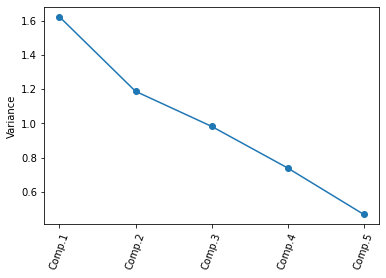

In [11]:
fig = plt.gcf()
def screeplot(pca, standardised_values):
    y = np.std(pca.transform(standardised_values), axis=0)**2
    x = np.arange(len(y)) + 1
    plt.plot(x, y, "o-")
    plt.xticks(x, ["Comp."+str(i) for i in x], rotation=70)
    plt.ylabel("Variance")
    #fig.set_size_inches(22, 8, forward=True)
    plt.show()

screeplot(pca, standardisedX)


The most obvious change in slope in the scree plot occurs at component 5, which is the "elbow" of the scree plot. Therefore, 
the first five components should be retained.

Second way:
Kaiser’s criterion

In [12]:
(summary.sdev**2).head(40)

,Standard deviation
PC1,1.621815
PC2,1.187083
PC3,0.982523
PC4,0.739686
PC5,0.468893


We should only retain principal components for which the variance is above 1.We see that the variance is above 1
for principal components 1, 2,...,5.

Third way:at least 75% of the variance

In [13]:
(summary.cumprop).head(45)

,Cumulative Proportion
PC1,0.324363
PC2,0.561780
PC3,0.758284
PC4,0.906221
PC5,1.000000


We would retain the first 5 principal components, as we can see from cumulative proportions that the 5 principal components explain 75.82% of the variance 

**Loadings for the Principal Components**

In [14]:
pca.components_[0]

array([-0.33771585,  0.63054   ,  0.65734964,  0.1157291 , -0.20703996])

**Values for 1st principal component**

In [15]:
pca.transform(standardisedX)[:, 0]

array([ 0.55091643, -1.61050346, -1.54079369, -0.79375855, -0.90863582,
        0.4326843 , -1.11956612,  0.41316028,  0.9781899 ,  1.95819686,
        0.28533709,  0.527914  , -0.49886909,  1.70828255,  1.99009057,
        2.21970752, -0.79375855,  0.79199422, -1.68021323,  1.14171103,
        0.90481143, -0.07507197, -1.72337543, -1.41103399,  0.26910842,
       -1.60161218, -0.9331781 ,  0.44763552, -0.29148393,  0.18444742,
       -0.53250696, -0.40442469,  1.07792567,  1.13622937, -0.04156963,
        1.29594627,  2.00510852,  2.19921989,  0.92710005, -1.74992301,
        0.49602029, -0.18279016,  1.15472574, -0.88285681,  0.67538476,
        0.60296991,  1.30754263, -0.0661119 , -1.7930852 , -0.63571908,
       -0.95984923, -2.13571171, -1.54079369, -0.77693961, -1.54079369,
       -1.54079369,  1.36946027, -0.07351809, -1.20782702,  0.86170399,
       -0.67372749,  1.07612469, -0.47052053,  2.36808714, -1.16466483,
       -0.14748683,  0.17285107, -1.81963278, -1.5750646 ,  3.11

In [16]:
pca.components_[1]

array([ 0.38617829,  0.30697674,  0.16493613, -0.74933003,  0.40979529])

**Scatterplots of the Principal Components**

C:\Users\User\anaconda3\envs\statistics\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0      2.0
1      2.0
2      2.0
3      5.0
4      5.0
      ... 
238    1.0
239    4.0
240    5.0
241    0.0
242    1.0
Name: V1, Length: 243, dtype: float64


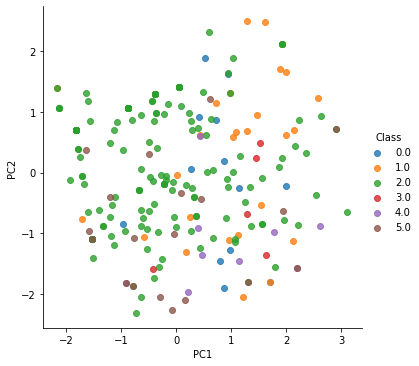

In [17]:
y=data["V1"]
def pca_scatter(pca, standardised_values, classifs):
    foo = pca.transform(standardised_values)
    bar = pd.DataFrame(zip(foo[:, 0], foo[:, 1], classifs), columns=["PC1", "PC2", "Class"])
    sns.lmplot("PC1", "PC2", bar, hue="Class", fit_reg=False)

pca_scatter(pca, standardisedX, y)
print(y)

The scatterplot shows the first principal component on the x-axis, and the second principal component on the y-axis. We can see from the scatterplot that samples of "Atomikh epixeirish" have much lower values of the first principal component than samples of "AE". Therefore, the first principal component separates samples of "Atomikh epixeirish" from those of "AE".

We can also see that samples of "AE","OE","allh morfh","IKE","APE" have low values of the second principal component.

**LDA**

In [18]:
lda = LinearDiscriminantAnalysis().fit(X, y)

**Loadings for the Discriminant Functions**

In [19]:
def pretty_scalings(lda, X, out=False):
    ret = pd.DataFrame(lda.scalings_, index=X.columns, columns=["LD"+str(i+1) for i in range(lda.scalings_.shape[1])])
    if out:
        print("Coefficients of linear discriminants:")
        display(ret)
    return ret

pretty_scalings_ = pretty_scalings(lda, X, out=True)

Coefficients of linear discriminants:


,LD1,LD2,LD3,LD4,LD5
V14,0.389674,-0.198773,0.098611,-0.042908,0.264682
V74,-0.221458,-0.148644,0.600072,0.636005,0.133859
V75,-0.180115,-0.506931,-0.130044,-0.608328,-0.034785
V12,-0.248248,0.126552,-0.042649,-0.021511,0.561962
V34,-0.131904,-0.460641,-0.561072,0.404040,0.153306


**Values of the first discriminant function**

In [20]:
lda.fit_transform(X, y)[:, 0]

array([ 1.17727094e+00,  5.79535247e-01,  3.31286878e-01, -3.25676770e-01,
       -1.22740714e+00, -4.58951015e-01,  3.58077619e-01, -1.54961524e+00,
       -1.50897410e+00, -2.01062870e+00, -8.98786542e-01,  5.60100567e-01,
        7.35852268e-01, -1.90551519e+00, -1.38222771e+00, -1.96141025e+00,
       -3.25676770e-01, -1.33838026e+00,  8.27783616e-01, -2.22601500e-01,
       -4.78725427e-01, -1.18505627e+00,  2.11918749e+00,  9.30519154e-01,
        6.53983455e-01,  5.90765864e-01,  1.70819969e-01,  4.29872527e-01,
       -1.27561762e+00,  1.34082820e-02, -1.15927350e+00, -9.27287014e-01,
       -1.18756083e+00, -1.89864761e+00, -1.38073113e+00, -1.92107532e+00,
        4.06074817e-01, -2.12697282e+00, -1.15390250e+00,  1.07603199e+00,
       -6.83004188e-02, -4.34947392e-02, -5.83838932e-01,  9.22707996e-01,
       -2.08049346e-01, -1.02902318e-01, -1.76674336e+00,  1.74959798e-02,
        2.36743586e+00, -7.15350273e-01,  3.35649907e-01,  2.10362736e+00,
        3.31286878e-01,  

**Standardisation**

In [21]:
def calcWithinGroupsVariance(variable, groupvariable):
    # find out how many values the group variable can take
    levels = sorted(set(groupvariable))
    numlevels = len(levels)
    # get the mean and standard deviation for each group:
    numtotal = 0
    denomtotal = 0
    for leveli in levels:
        levelidata = variable[groupvariable==leveli]
        levelilength = len(levelidata)
        # get the standard deviation for group i:
        sdi = np.std(levelidata)
        numi = (levelilength)*sdi**2
        denomi = levelilength
        numtotal = numtotal + numi
        denomtotal = denomtotal + denomi
    # calculate the within-groups variance
    Vw = numtotal / (denomtotal - numlevels)
    return Vw

In [22]:
def groupStandardise(variables, groupvariable):
    # find the number of samples in the data set and the number of variables
    numsamples, numvariables = variables.shape
    # find the variable names
    variablenames = variables.columns
    # calculate the group-standardised version of each variable
    variables_new = pd.DataFrame()
    for i in range(numvariables):
        variable_name = variablenames[i]
        variablei = variables[variable_name]
        variablei_Vw = calcWithinGroupsVariance(variablei, groupvariable)
        variablei_mean = np.mean(variablei)
        variablei_new = (variablei - variablei_mean)/(np.sqrt(variablei_Vw))
        variables_new[variable_name] = variablei_new
    return variables_new

In [23]:
groupstandardisedX = groupStandardise(X, y)

In [24]:
lda2 = LinearDiscriminantAnalysis().fit(groupstandardisedX, y)
pretty_scalings(lda2, groupstandardisedX)

,LD1,LD2,LD3,LD4,LD5
V14,0.751712,-0.383449,0.190229,-0.082773,0.510593
V74,-0.274688,-0.184373,0.744308,0.788878,0.166034
V75,-0.251525,-0.707915,-0.181603,-0.849512,-0.048576
V12,-0.402378,0.205124,-0.069129,-0.034866,0.910867
V34,-0.157721,-0.550799,-0.670887,0.483119,0.183312


**Calculation of the value of the first discriminant function**

In [25]:
lda2.fit_transform(groupstandardisedX, y)[:, 0]

array([ 1.17727094e+00,  5.79535247e-01,  3.31286878e-01, -3.25676770e-01,
       -1.22740714e+00, -4.58951015e-01,  3.58077619e-01, -1.54961524e+00,
       -1.50897410e+00, -2.01062870e+00, -8.98786542e-01,  5.60100567e-01,
        7.35852268e-01, -1.90551519e+00, -1.38222771e+00, -1.96141025e+00,
       -3.25676770e-01, -1.33838026e+00,  8.27783616e-01, -2.22601500e-01,
       -4.78725427e-01, -1.18505627e+00,  2.11918749e+00,  9.30519154e-01,
        6.53983455e-01,  5.90765864e-01,  1.70819969e-01,  4.29872527e-01,
       -1.27561762e+00,  1.34082820e-02, -1.15927350e+00, -9.27287014e-01,
       -1.18756083e+00, -1.89864761e+00, -1.38073113e+00, -1.92107532e+00,
        4.06074817e-01, -2.12697282e+00, -1.15390250e+00,  1.07603199e+00,
       -6.83004188e-02, -4.34947392e-02, -5.83838932e-01,  9.22707996e-01,
       -2.08049346e-01, -1.02902318e-01, -1.76674336e+00,  1.74959798e-02,
        2.36743586e+00, -7.15350273e-01,  3.35649907e-01,  2.10362736e+00,
        3.31286878e-01,  

**Separation Achieved by the Discriminant Functions**

In [26]:
def rpredict(lda, X, y, out=False):
    ret = {"class": lda.predict(X),
           "posterior": pd.DataFrame(lda.predict_proba(X), columns=lda.classes_)}
    ret["x"] = pd.DataFrame(lda.fit_transform(X, y))
    ret["x"].columns = ["LD"+str(i+1) for i in range(ret["x"].shape[1])]
    if out:
        print("class")
        print(ret["class"])
        print()
        print("posterior")
        print(ret["posterior"])
        print()
        print("x")
        print(ret["x"])
    return ret

lda_values = rpredict(lda, standardisedX, y, True)

class
[2. 2. 2. 5. 5. 5. 2. 2. 5. 2. 2. 2. 2. 5. 2. 5. 5. 5. 2. 2. 2. 5. 2. 2.
 2. 2. 5. 2. 5. 2. 2. 5. 5. 5. 2. 2. 2. 5. 2. 2. 2. 2. 2. 2. 2. 2. 5. 2.
 2. 5. 2. 2. 2. 2. 2. 2. 5. 2. 2. 5. 2. 2. 2. 2. 2. 2. 2. 2. 2. 5. 5. 2.
 2. 2. 2. 2. 5. 2. 2. 2. 5. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 5. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 5. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 5. 5. 2. 2. 2. 2. 2. 5. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 5. 5. 5. 2. 5. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 5. 2. 2. 5. 2. 2. 2. 2. 2. 5. 2. 2. 2. 2. 5. 2. 2.
 2. 2. 5.]

posterior
          0.0       1.0       2.0       3.0       4.0       5.0
0    0.010797  0.016855  0.765092  0.000212  0.010285  0.196759
1    0.014628  0.004661  0.650769  0.000708  0.025113  0.304120
2    0.016074  0.004722  0.606028  0.000936  0.032

In [29]:
def calcBetweenGroupsVariance(variable, groupvariable):
    # find out how many values the group variable can take
    levels = sorted(set((groupvariable)))
    numlevels = len(levels)
    # calculate the overall grand mean:
    grandmean = np.mean(variable)
    # get the mean and standard deviation for each group:
    numtotal = 0
    denomtotal = 0
    for leveli in levels:
        levelidata = variable[groupvariable==leveli]
        levelilength = len(levelidata)
        # get the mean and standard deviation for group i:
        meani = np.mean(levelidata)
        sdi = np.std(levelidata)
        numi = levelilength * ((meani - grandmean)**2)
        denomi = levelilength
        numtotal = numtotal + numi
        denomtotal = denomtotal + denomi
    # calculate the between-groups variance
    Vb = numtotal / (numlevels - 1)
    return(Vb)
def calcSeparations(variables, groupvariable):
    # calculate the separation for each variable
    for variablename in variables:
        variablei = variables[variablename]
        Vw = calcWithinGroupsVariance(variablei, groupvariable)
        Vb = calcBetweenGroupsVariance(variablei, groupvariable)
        sep = Vb/Vw
        print("variable", variablename, "Vw=", Vw, "Vb=", Vb, "separation=", sep)
calcSeparations(lda_values["x"], y)

variable LD1 Vw= 1.0000000000000009 Vb= 17.062153148553286 separation= 17.06215314855327
variable LD2 Vw= 1.000000000000001 Vb= 7.263200441136367 separation= 7.263200441136359
variable LD3 Vw= 0.9999999999999994 Vb= 1.1123375189160638 separation= 1.1123375189160645
variable LD4 Vw= 0.9999999999999996 Vb= 0.5727163134161033 separation= 0.5727163134161035
variable LD5 Vw= 1.0000000000000007 Vb= 0.0010887072742777723 separation= 0.0010887072742777717


In [30]:
def proportion_of_trace(lda):
    ret = pd.DataFrame([round(i, 4) for i in lda.explained_variance_ratio_ if round(i, 4) > 0], columns=["ExplainedVariance"])
    ret.index = ["LD"+str(i+1) for i in range(ret.shape[0])]
    ret = ret.transpose()
    print("Proportion of trace:")
    print(ret.to_string(index=False))
    return ret

proportion_of_trace(LinearDiscriminantAnalysis(solver="eigen").fit(X, y));

Proportion of trace:
    LD1     LD2     LD3    LD4
 0.6559  0.2792  0.0428  0.022


Therefore, the first discriminant function does achieve a good separation between the six groups , but the second discriminant function does improve the separation of the groups by quite a large amount, so is it worth using the second discriminant function as well. Therefore, to achieve a good separation of the groups , it is necessary to use both of the first two discriminant functions.

**A Stacked Histogram of the LDA Values**

In [31]:
def ldahist(data, g, sep=False):
    xmin = np.trunc(np.min(data)) - 1
    xmax = np.trunc(np.max(data)) + 1
    ncol = len(set(g))
    binwidth = 0.5
    bins=np.arange(xmin, xmax + binwidth, binwidth)
    if sep:
        fig, axl = plt.subplots(ncol, 1, sharey=True, sharex=True)
    else:
        fig, axl = plt.subplots(1, 1, sharey=True, sharex=True)
        axl = [axl]*ncol
    for ax, (group, gdata) in zip(axl, data.groupby(g)):
        sns.distplot(gdata.values, bins, ax=ax, label="group "+str(group))
        ax.set_xlim([xmin, xmax])
        if sep:
            ax.set_xlabel("group"+str(group))
        else:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

C:\Users\User\anaconda3\envs\statistics\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\envs\statistics\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\envs\statistics\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

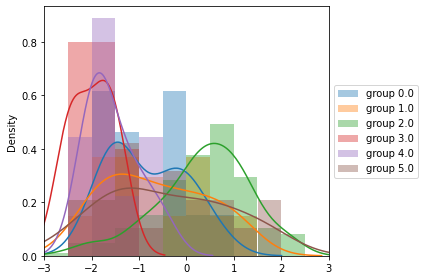

In [32]:
ldahist(lda_values["x"].LD1, y)


We can see from the histogram that there is an overlapping between groups ,however groups 2 and 3 seem to be better separated than the other group.

C:\Users\User\anaconda3\envs\statistics\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\envs\statistics\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\envs\statistics\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

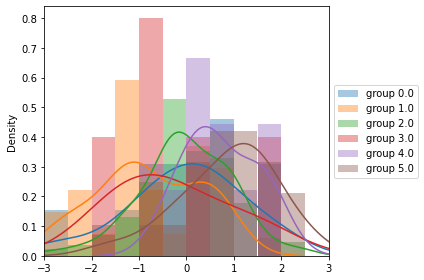

In [33]:
ldahist(lda_values["x"].LD2, y)

The overlapping is obvious.

Thus, we see that the second discriminant function is not necessary to separate the groups

 **Scatterplots of the Discriminant Functions**

C:\Users\User\anaconda3\envs\statistics\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


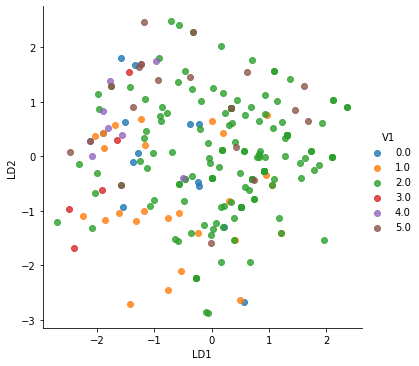

In [34]:
sns.lmplot("LD1", "LD2", lda_values["x"].join(y), hue="V1", fit_reg=False);

The scatterplot shows the LD1 on the x-axis, and the LD2 on the y-axis. We can see from the scatterplot that samples of "Atomikh epixeirish" have much higher values of the LD1 than samples of "AE". 

**Allocation Rules and Misclassification Rate**

In [36]:
def printMeanAndSdByGroup(variables, groupvariable):
    data_groupby = variables.groupby(groupvariable)
    print("## Means:")
    display(data_groupby.apply(np.mean))
    print("\n## Standard deviations:")
    display(data_groupby.apply(np.std))
    print("\n## Sample sizes:")
    display(pd.DataFrame(data_groupby.apply(len)))
printMeanAndSdByGroup(lda_values["x"], y);

## Means:


,LD1,LD2,LD3,LD4,LD5
V1,,,,,
0.0,-0.833977,-0.015314,0.298374,0.344593,0.006249
1.0,-0.632103,-0.798119,0.128835,-0.148480,0.000283
2.0,0.350477,0.002112,-0.029651,0.014415,-0.000725
3.0,-1.984515,-0.284827,-0.855852,0.109286,0.007951
4.0,-1.554045,0.719535,0.047533,-0.001012,-0.018669
5.0,-0.408611,0.859871,0.080776,-0.182036,0.008558



## Standard deviations:


,LD1,LD2,LD3,LD4,LD5
V1,,,,,
0.0,0.774357,1.161669,1.242282,1.184615,0.900411
1.0,1.042849,1.065671,1.045824,1.249555,1.059769
2.0,0.991539,0.969035,0.980669,0.917157,1.017643
3.0,0.407555,1.114743,0.604531,1.689736,0.415766
4.0,0.516489,0.711064,1.033804,0.830633,0.341160
5.0,1.245513,0.983963,0.810108,0.830781,0.977995



## Sample sizes:


,0
V1,
0.0,13
1.0,27
2.0,170
3.0,5
4.0,9
5.0,19


We find that the mean value of the first discriminant function is -0.833977 for group 1, -0.632103	 for group 2, and 0.350477 for group 3,-1.984515 for group 4,-1.554045 for group 5,-0.408611 for group 6. The 
mid-way point between the mean values for group 1 and 2 is (-1.984515-1.554045)/2=-1.76928,  
mid-way point between the mean values for group 2 and 3 is (-1.554045-0.833977)/2=-1.194011,
mid-way point between the mean values for group 3 and 4 is (-0.833977-0.632103)/2=-0.7330399,
mid-way point between the mean values for group 4 and 5 is (-0.632103-0.408611)/2=-0.520357,
mid-way point between the mean values for group 5 and 6 is (-0.408611+0.350477)/2=-0.0290670

Therefore, we can use the following allocation rule:

if the first discriminant function is <=-1.76928, predict the sample to be from group 4

if the first discriminant function is > -1.76928 and <= -1.194011, predict the sample to be from group 5

if the first discriminant function is >-1.194011 and <= -0.7330399, predict the sample to be from group 1

if the first discriminant function is >-0.7330399  and <= -0.520357, predict the sample to be from group 2

if the first discriminant function is >-0.520357 and <= -0.0290670, predict the sample to be from group 6

if the first discriminant function is >-0.0290670, predict the sample to be from group 3

In [72]:
def webprint_confusion_matrix(confusion_matrix, classes_names):
    i=0
    display(pd.DataFrame(confusion_matrix, index=["Is group "+ str(i) for i in classes_names], columns=["Allocated to group "+ str(i) for i in classes_names]))

In [73]:
import sklearn.metrics as metrics

def lda_classify(v, levels, cutoffpoints):
    for level, cutoff in zip(reversed(levels), reversed(cutoffpoints)):
        if v > cutoff: return level
    return levels[0]
    
y_pred = lda_values["x"].iloc[:, 0].apply(lda_classify, args=(lda.classes_, [-1.76928,-1.194011, -0.7330399, -0.520357, -0.0290670],)).values
y_true = y

In [75]:
# from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#example-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

print(metrics.classification_report(y_true, y_pred))
cm = metrics.confusion_matrix(y_true, y_pred)
webprint_confusion_matrix(cm, lda.classes_)
#cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#plot_confusion_matrix(cm_normalized, lda.classes_, title='Normalized confusion matrix')

              precision    recall  f1-score   support

         0.0       0.04      0.08      0.06        13
         1.0       0.21      0.19      0.20        27
         2.0       0.63      0.07      0.13       170
         3.0       0.00      0.00      0.00         5
         4.0       0.04      0.11      0.06         9
         5.0       0.06      0.42      0.10        19

    accuracy                           0.11       243
   macro avg       0.16      0.14      0.09       243
weighted avg       0.47      0.11      0.12       243



,Allocated to group 0.0,Allocated to group 1.0,Allocated to group 2.0,Allocated to group 3.0,Allocated to group 4.0,Allocated to group 5.0
Is group 0.0,1,6,0,0,4,2
Is group 1.0,5,5,4,2,2,9
Is group 2.0,7,4,12,8,18,121
Is group 3.0,3,2,0,0,0,0
Is group 4.0,5,2,1,0,1,0
Is group 5.0,2,5,2,0,2,8
